In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [13]:
df_incident = pd.read_json('../data/raw/incident.json')  
df_incident.head()



,Incident Number,Creation Date,Fatal Injury Victim,Concussion Intracranial Inju,Burns Severe,Burns Minor,Whiplash,Spinal Injury,Amputation,Injury Leading Deafness,...,No Injury,elevating devices number,Specific Root Cause,Reported occurrence narrative,Time of Occurrence,Summarized detail of Inspection and tests,Inspector's Conclusion,Incident Summary,Task Number,release
0,518574,14-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22202,None,Elevator-Flood on 13th floor ran down the stai...,2:00:00 PM,None,None,ED-Near Miss,3200103,yes
1,518582,14-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22203,None,Elevator-Flood on 13th floor ran down stairs a...,2:00:00 PM,None,None,ED-Near Miss,3200141,yes
2,519464,17-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,87727,None,Elevator-Man with dog tried to kick dog leash ...,12:00:00 AM,None,None,ED-Incident,3202552,yes
3,524274,27-Jan-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17594,None,Elevator - a piece of trim fell on person in e...,12:00:00 AM,None,None,ED-Incident,3212548,yes
4,519720,18-Jan-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,81630,None,Elevator-Elderly man exiting elevator got hit ...,7:30:00 PM,None,None,ED-Incident,3203135,yes


In [9]:
df_incident.isnull().sum()

Incident Number                                 0
Creation Date                                   0
Fatal Injury Victim                          1384
Concussion Intracranial Inju                 1384
Burns Severe                                 1384
Burns Minor                                  1384
Whiplash                                     1384
Spinal Injury                                1384
Amputation                                   1384
Injury Leading Deafness                      1384
Heart Attack                                 1384
Fracture Major Bone                          1384
Eye Injury                                   1384
Electric Shock Severe                        1384
Electric Shock Minor                         1384
Dislocation Limb                             1384
Bruise Hemorrhage Interna                    1384
Exposure Carcinomatou Poison                 1384
Swelling                                     1384
Sprained Twisted Joints Muscle               1384


In [10]:
df_incident.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Incident Number                            2446 non-null   int64  
 1   Creation Date                              2446 non-null   object 
 2   Fatal Injury Victim                        1062 non-null   float64
 3   Concussion Intracranial Inju               1062 non-null   float64
 4   Burns Severe                               1062 non-null   float64
 5   Burns Minor                                1062 non-null   float64
 6   Whiplash                                   1062 non-null   float64
 7   Spinal Injury                              1062 non-null   float64
 8   Amputation                                 1062 non-null   float64
 9   Injury Leading Deafness                    1062 non-null   float64
 10  Heart Attack            

In [15]:
# 2. Fill missing values in the key column
df_incident['Reported occurrence narrative'] = (
    df_incident['Reported occurrence narrative'].fillna('')
)

In [17]:
# 3. Prepare for text cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [18]:
# 4. Apply cleaning to create a new column
df_incident['cleaned_text'] = df_incident['Reported occurrence narrative'].apply(clean_text)

In [19]:
# 5. Inspect the result
df_incident.head()


,Incident Number,Creation Date,Fatal Injury Victim,Concussion Intracranial Inju,Burns Severe,Burns Minor,Whiplash,Spinal Injury,Amputation,Injury Leading Deafness,...,elevating devices number,Specific Root Cause,Reported occurrence narrative,Time of Occurrence,Summarized detail of Inspection and tests,Inspector's Conclusion,Incident Summary,Task Number,release,cleaned_text
0,518574,14-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22202,None,Elevator-Flood on 13th floor ran down the stai...,2:00:00 PM,None,None,ED-Near Miss,3200103,yes,elevatorflood 13th floor ran stair elevator
1,518582,14-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22203,None,Elevator-Flood on 13th floor ran down stairs a...,2:00:00 PM,None,None,ED-Near Miss,3200141,yes,elevatorflood 13th floor ran stair elevator in...
2,519464,17-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87727,None,Elevator-Man with dog tried to kick dog leash ...,12:00:00 AM,None,None,ED-Incident,3202552,yes,elevatorman dog tried kick dog leash elevator ...
3,524274,27-Jan-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17594,None,Elevator - a piece of trim fell on person in e...,12:00:00 AM,None,None,ED-Incident,3212548,yes,elevator piece trim fell person elevator sore ...
4,519720,18-Jan-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,81630,None,Elevator-Elderly man exiting elevator got hit ...,7:30:00 PM,None,None,ED-Incident,3203135,yes,elevatorelderly man exiting elevator got hit d...


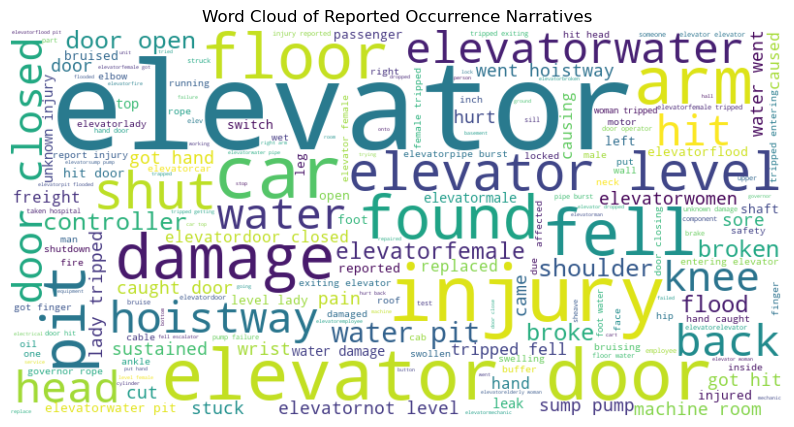

In [25]:
# Now, let's combine all the cleaned text into one big string!
all_text = " ".join(df_incident['cleaned_text'].tolist())

# Then, we can create the word cloud...
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(all_text)

# And finally, let's see how it looks
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Reported Occurrence Narratives")
plt.show()


In [ ]:
# It looks good for now, so we can save it in our reports dir
wordcloud.to_file('../reports/figures